In [34]:
#packages related to dataframes
import pandas as pd
import numpy as np
from pathlib import Path
import csv
import panel as pn
import seaborn as sns
import hvplot.pandas
%matplotlib

#package to help convert a stringify array back to array
import ast

#package needed to assign user a unique id 
import uuid

# Importing helper function from utils folder 
import sys
sys.path.append('Resources/utils')
from user_form_intake import inital_user_intake, get_user_inital_input, portfolio_user_intake, get_user_portfolio_input

Using matplotlib backend: <object object at 0x137ae86e0>


# Grabbing the Data Files 

In [35]:
#Grabing the raw stock data and putting in dataframe
raw_stocks_data_to_load =  Path("Resources/Data/Stock_Index_Raw_Data.csv")
raw_stocks_data_df = pd.read_csv(raw_stocks_data_to_load, header=0, parse_dates=True, index_col="Date", infer_datetime_format=True)
raw_stocks_data_df.sort_index(ascending = True, inplace = True)
raw_stocks_data_df.head()

,Company,Ticker,Close_Price,Industry,Sector
Date,,,,,
2023-02-01,Apple,AAPL,145.43,Computer Manufacturing,Technology
2023-02-01,Amazon,AMZN,105.15,Catalog/Specialty Distribution,Consumer Discretionary
2023-02-01,Nvidia,NVDA,209.43,Semiconductors,Technology
2023-02-01,Alphabet,GOOGL,100.43,"Computer Software: Programming, Data Processing",Technology
2023-02-01,Meta,META,153.12,"Computer Software: Programming, Data Processing",Technology


In [36]:
#Grabing the raw stock data and putting in dataframe
user_data_to_load =  Path("Resources/Data/User_Portfolio_Data.csv")
user_data_df = pd.read_csv(user_data_to_load, header=0, parse_dates=True)
user_data_df.sort_index(ascending = True, inplace = True)
user_data_df.head()

,UUID,User_Name,Sharpe_Ratio,Stocks
0,85c7d8c0-c991-4824-8f4d-37535e5851bc,John,3.540897,"['AAPL', 'AVGO', 'UNH', 'NVDA', 'V']"
1,9911f3d6-2a1e-4956-b676-d14ddd12fe0e,alex_1,3.412431,"['NVDA', 'AMZN', 'AAPL', 'MSFT']"
2,db136baa-8bbd-470c-ae3c-38f6340ba7bd,Edward,3.337273,"['BRK.B', 'AAPL', 'XOM', 'UNH', 'NVDA', 'MSFT']"
3,866a252f-1fe7-4a3c-859f-ea1eb81f9348,Amy,3.296707,"['BRK.B', 'AAPL', 'XOM', 'MSFT', 'META']"
4,0331b7dd-f698-405a-912d-a6dd5c153436,Alissa,3.261231,"['NVDA', 'AAPL', 'XOM', 'MSFT', 'UNH', 'AMZN']"


# User Input for Game of Stocks

In [37]:
# Invoking the user intake form 1. It will store the information in the following variables so it can be used in notebook later.

inital_user_intake()

Welcome to the Game of Stocks! You will be asked a series of questions to get started. 
    You can choose up to 10 stickes to create portfolio. Remember to diversify your portfolio.   


Textarea(value='Input your name', description='First Name:', placeholder='Type something')

Dropdown(description='Amount', index=10, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'Choose Stock Amount:'), valu…

Button(description='Submit', style=ButtonStyle())

In [38]:
# Getting the form values that was store in name, num_of_stocks_choosen 
name, num_of_stocks_choosen = get_user_inital_input()

In [39]:
# Invoking function to output dropdown for the stock selection for the number of stocks user selected in their intake form

portfolio_user_intake(num_of_stocks_choosen)

Dropdown(description='Stock 1:', options=('', 'Apple (AAPL) - Computer Manufacturing', 'Microsoft (MSFT) - Com…

Button(description='Submit', style=ButtonStyle())

In [40]:
# getting the user chosen portfolio
unique_user_portfolio_array = get_user_portfolio_input()

unique_user_portfolio_array

['AAPL']

In [41]:
#calculating individual weights since we will assume it will be evenly split
weight = round((1/len(unique_user_portfolio_array)),5)

weight

1.0

In [42]:
#creating the weight array to apply to stocks
weight_array = [weight] * len(unique_user_portfolio_array)
weight_array

[1.0]

# User Portfolio Calculations 

In [43]:
# Get data from file for tickers in unique_user_portfolio_array using ".loc" and ".isin"
portfolio_returns = raw_stocks_data_df.loc[raw_stocks_data_df["Ticker"].isin(unique_user_portfolio_array)]

# Filter columns to get only the Ticker and Close Price and drop null values
portfolio_returns= portfolio_returns[["Ticker","Close_Price"]].dropna()

# Set tickers as columns
portfolio_returns= portfolio_returns.pivot_table("Close_Price","Date","Ticker")

# Calculate daily returns using "pct_change" and drop null values 
portfolio_returns = portfolio_returns.pct_change().dropna()

# Display data
portfolio_returns.head()

Ticker,AAPL
Date,
2023-02-02,0.037063
2023-02-03,0.024400
2023-02-06,-0.017929
2023-02-07,0.019245
2023-02-08,-0.017653


In [44]:
# Create portfolio variable in dataframe with weights using ".dot"
portfolio_returns["Portfolio"] = portfolio_returns.dot(weight_array)
portfolio_returns.head()

Ticker,AAPL,Portfolio
Date,,
2023-02-02,0.037063,0.037063
2023-02-03,0.024400,0.024400
2023-02-06,-0.017929,-0.017929
2023-02-07,0.019245,0.019245
2023-02-08,-0.017653,-0.017653


In [45]:
# use to store in user portfolio table 
user_sharpe_ratio= (portfolio_returns["Portfolio"].mean() * (252)) / (portfolio_returns["Portfolio"].std() * np.sqrt(252))
user_sharpe_ratio

3.243118980431322

In [46]:
portfolio_cum_return = (1 + portfolio_returns).cumprod()
portfolio_cum_return.plot()

<Axes: xlabel='Date'>

# Storing User Info In User Portfolio CSV and Updating The Rank 

In [47]:
#getting a uuid 
unique_id = uuid.uuid4()

#converting uuid to string so it can store as a string in csv and easier to use loc
user_uuid_str = str(unique_id)
print("UUID as string:", user_uuid_str)

UUID as string: 44ef2f2d-ebff-419f-8aad-d2d7fa534919


In [48]:
# Create a list of dictionaries (each dictionary represents a row of data)
user_data = [{'UUID': user_uuid_str,
              'User_Name': name,
              'Sharpe_Ratio': user_sharpe_ratio,
              'Stocks': f'{unique_user_portfolio_array}'}]

# Create the DataFrame from the list of dictionaries
user_portfolio_df = pd.DataFrame(user_data)

In [49]:
# Append the new row to the DataFrame
# user_data_df = user_data_df.append(user_data, ignore_index=True)

# Concatenate the original DataFrame and the new row DataFrame
user_data_df = pd.concat([user_data_df, user_portfolio_df], ignore_index=True)

# Write the updated DataFrame back to the CSV file
user_data_df.to_csv(user_data_to_load, index=False)

#Print so user can see what was added 
print("New User row added to the User User_Portfolio_Data.csv file. The following was added:")
display(user_portfolio_df)

New User row added to the User User_Portfolio_Data.csv file. The following was added:


,UUID,User_Name,Sharpe_Ratio,Stocks
0,44ef2f2d-ebff-419f-8aad-d2d7fa534919,Jim,3.243119,['AAPL']


# TOP 5 users BEFORE the rank is updated 

In [50]:
user_data_df.head()

,UUID,User_Name,Sharpe_Ratio,Stocks
0,85c7d8c0-c991-4824-8f4d-37535e5851bc,John,3.540897,"['AAPL', 'AVGO', 'UNH', 'NVDA', 'V']"
1,9911f3d6-2a1e-4956-b676-d14ddd12fe0e,alex_1,3.412431,"['NVDA', 'AMZN', 'AAPL', 'MSFT']"
2,db136baa-8bbd-470c-ae3c-38f6340ba7bd,Edward,3.337273,"['BRK.B', 'AAPL', 'XOM', 'UNH', 'NVDA', 'MSFT']"
3,866a252f-1fe7-4a3c-859f-ea1eb81f9348,Amy,3.296707,"['BRK.B', 'AAPL', 'XOM', 'MSFT', 'META']"
4,0331b7dd-f698-405a-912d-a6dd5c153436,Alissa,3.261231,"['NVDA', 'AAPL', 'XOM', 'MSFT', 'UNH', 'AMZN']"


In [51]:
#Sort user portfolio table to get new ranking. Sort by descending since higher sharpe ratio the better 
sorted_user_data_df = user_data_df.sort_values(by='Sharpe_Ratio', ascending=False)

# TOP 5 Players AFTER Rank is Updated

In [52]:
sorted_user_data_df.head()

,UUID,User_Name,Sharpe_Ratio,Stocks
0,85c7d8c0-c991-4824-8f4d-37535e5851bc,John,3.540897,"['AAPL', 'AVGO', 'UNH', 'NVDA', 'V']"
1,9911f3d6-2a1e-4956-b676-d14ddd12fe0e,alex_1,3.412431,"['NVDA', 'AMZN', 'AAPL', 'MSFT']"
2,db136baa-8bbd-470c-ae3c-38f6340ba7bd,Edward,3.337273,"['BRK.B', 'AAPL', 'XOM', 'UNH', 'NVDA', 'MSFT']"
3,866a252f-1fe7-4a3c-859f-ea1eb81f9348,Amy,3.296707,"['BRK.B', 'AAPL', 'XOM', 'MSFT', 'META']"
4,0331b7dd-f698-405a-912d-a6dd5c153436,Alissa,3.261231,"['NVDA', 'AAPL', 'XOM', 'MSFT', 'UNH', 'AMZN']"


In [53]:
#Save new rank to user User_Portfolio_Data.csv Write the updated DataFrame back to the CSV file

sorted_user_data_df.to_csv(user_data_to_load, index=False)

#have to re-import the user portfolio data to get updated sorted list 
user_data_df = pd.read_csv(user_data_to_load, header=0, parse_dates=True)
user_data_df.sort_index(ascending = True, inplace = True)

In [54]:
#User Ranking of top 5 AFTER rank is updated  
user_data_df.head()

,UUID,User_Name,Sharpe_Ratio,Stocks
0,85c7d8c0-c991-4824-8f4d-37535e5851bc,John,3.540897,"['AAPL', 'AVGO', 'UNH', 'NVDA', 'V']"
1,9911f3d6-2a1e-4956-b676-d14ddd12fe0e,alex_1,3.412431,"['NVDA', 'AMZN', 'AAPL', 'MSFT']"
2,db136baa-8bbd-470c-ae3c-38f6340ba7bd,Edward,3.337273,"['BRK.B', 'AAPL', 'XOM', 'UNH', 'NVDA', 'MSFT']"
3,866a252f-1fe7-4a3c-859f-ea1eb81f9348,Amy,3.296707,"['BRK.B', 'AAPL', 'XOM', 'MSFT', 'META']"
4,0331b7dd-f698-405a-912d-a6dd5c153436,Alissa,3.261231,"['NVDA', 'AAPL', 'XOM', 'MSFT', 'UNH', 'AMZN']"


In [55]:
# Grab Postition of User Ranking 

condition = user_data_df['UUID'] == user_uuid_str
matching_rows = user_data_df[condition]

# Get the index of the first matching row (if any)
if not matching_rows.empty:
    row_index = matching_rows.index[0]
#     print(f"Index of the row: {row_index}")
    print(f"{name}, your rank is {row_index + 1}" )
else:
    print("Error, user info not found")
    
rank = {row_index + 1}

Jim, your rank is 7


# User Performance Compared to Other Players Calulation and Market

In [56]:
# Create a dataframe for market indicators and calculate daily returns and drop nulls 
sp_returns = raw_stocks_data_df.loc[raw_stocks_data_df["Ticker"]=="SPX"]
sp_returns = sp_returns[["Close_Price"]].pct_change().dropna()

ndaq_returns = raw_stocks_data_df.loc[raw_stocks_data_df["Ticker"]=="NDAQ"]
ndaq_returns = ndaq_returns[["Close_Price"]].pct_change().dropna()

# Rename columns to SP500 and NDAQ
sp_returns.columns=["SP500"]
ndaq_returns.columns=["NDAQ"]

# Combine dataframes
market_returns = pd.concat([sp_returns, ndaq_returns], axis="columns", join="inner")
market_returns.head()

,SP500,NDAQ
Date,,
2023-02-02,0.014699,0.032540
2023-02-03,-0.010355,-0.015889
2023-02-06,-0.006140,-0.009953
2023-02-07,0.012873,0.019040
2023-02-08,-0.011081,-0.016780


In [57]:
# Create a dataframe for top players and calculate daily returns and drop nulls 

# Convert top stored user data from csv from stingify array back to a list so it can be used in calculations
top_1_str_to_list = ast.literal_eval(user_data_df.loc[0, 'Stocks'])
top_2_str_to_list = ast.literal_eval(user_data_df.loc[1, 'Stocks'])
top_3_str_to_list = ast.literal_eval(user_data_df.loc[2, 'Stocks'])

# Get data from file for tickers in user_data using ".loc" and ".isin"
top_1_portfolio_returns = raw_stocks_data_df.loc[raw_stocks_data_df["Ticker"].isin(top_1_str_to_list)]
top_2_portfolio_returns = raw_stocks_data_df.loc[raw_stocks_data_df["Ticker"].isin(top_2_str_to_list)]
top_3_portfolio_returns = raw_stocks_data_df.loc[raw_stocks_data_df["Ticker"].isin(top_3_str_to_list)]

# Filter columns to get only the Ticker and Close Price and drop null values
top_1_portfolio_returns = top_1_portfolio_returns[["Ticker","Close_Price"]].dropna()
top_2_portfolio_returns = top_2_portfolio_returns[["Ticker","Close_Price"]].dropna()
top_3_portfolio_returns = top_3_portfolio_returns[["Ticker","Close_Price"]].dropna()

# Set tickers as columns
top_1_portfolio_returns = top_1_portfolio_returns.pivot_table("Close_Price","Date","Ticker")
top_2_portfolio_returns = top_2_portfolio_returns.pivot_table("Close_Price","Date","Ticker")
top_3_portfolio_returns = top_3_portfolio_returns.pivot_table("Close_Price","Date","Ticker")

# Calculate daily returns using "pct_change" and drop null values 
top_1_portfolio_returns  = top_1_portfolio_returns .pct_change().dropna() 
top_2_portfolio_returns  = top_2_portfolio_returns .pct_change().dropna() 
top_3_portfolio_returns  = top_3_portfolio_returns .pct_change().dropna() 

# Get User name to locate portfolios
top_1_user_name = user_data_df.loc[0, 'User_Name']
top_2_user_name = user_data_df.loc[1, 'User_Name']
top_3_user_name = user_data_df.loc[2, 'User_Name']

# Get the porfolio using weights and keep only the porfolio column. Using numpy dot method to multiple the portfolio returns list with the weight list
top_1_portfolio_returns[f"{top_1_user_name}"] = top_1_portfolio_returns.dot([1/len(top_1_str_to_list)] * len(top_1_str_to_list))
top_1_portfolio_returns = top_1_portfolio_returns[[f"{top_1_user_name}"]]

top_2_portfolio_returns[f"{top_2_user_name}"] = top_2_portfolio_returns.dot([1/len(top_2_str_to_list)] * len(top_2_str_to_list))
top_2_portfolio_returns = top_2_portfolio_returns[[f"{top_2_user_name}"]]

top_3_portfolio_returns[f"{top_3_user_name}"] = top_3_portfolio_returns.dot([1/len(top_3_str_to_list)] * len(top_3_str_to_list))
top_3_portfolio_returns = top_3_portfolio_returns[[f"{top_3_user_name}"]]

top_returns = pd.concat([top_1_portfolio_returns, top_2_portfolio_returns, top_3_portfolio_returns], axis="columns", join="inner")
top_returns.head()


Ticker,John,alex_1,Edward
Date,,,
2023-02-02,0.004038,0.048580,0.006789
2023-02-03,-0.002419,-0.027897,-0.004760
2023-02-06,-0.001694,-0.009067,-0.003284
2023-02-07,0.020832,0.027996,0.026565
2023-02-08,-0.005698,-0.009871,-0.004844


In [58]:
# Join market_return, top players with portfolio 
top_portfolio_market_returns = pd.concat([portfolio_returns["Portfolio"], market_returns, top_returns], axis="columns", join="inner")
top_portfolio_market_returns.head()

,Portfolio,SP500,NDAQ,John,alex_1,Edward
Date,,,,,,
2023-02-02,0.037063,0.014699,0.032540,0.004038,0.048580,0.006789
2023-02-03,0.024400,-0.010355,-0.015889,-0.002419,-0.027897,-0.004760
2023-02-06,-0.017929,-0.006140,-0.009953,-0.001694,-0.009067,-0.003284
2023-02-07,0.019245,0.012873,0.019040,0.020832,0.027996,0.026565
2023-02-08,-0.017653,-0.011081,-0.016780,-0.005698,-0.009871,-0.004844


In [59]:
# Calculate sharp ratio - visulaize purposes - Portfolio and the Index
top_portfolio_market_sharp_ratio = (top_portfolio_market_returns.mean() * (252)) / (top_portfolio_market_returns.std() * np.sqrt(252))
top_portfolio_market_sharp_ratio

Portfolio    3.243119
SP500        1.739253
NDAQ         2.337676
John         3.540897
alex_1       3.412431
Edward       3.337273
dtype: float64

In [60]:
# Calculate cumulative returns to create plot
top_portfolio_market_stocks_cum_return = (1 + top_portfolio_market_returns).cumprod()
top_portfolio_market_stocks_cum_return.head()

,Portfolio,SP500,NDAQ,John,alex_1,Edward
Date,,,,,,
2023-02-02,1.037063,1.014699,1.032540,1.004038,1.048580,1.006789
2023-02-03,1.062367,1.004193,1.016134,1.001609,1.019328,1.001996
2023-02-06,1.043320,0.998026,1.006020,0.999912,1.010085,0.998706
2023-02-07,1.063398,1.010873,1.025175,1.020742,1.038364,1.025237
2023-02-08,1.044626,0.999672,1.007972,1.014926,1.028113,1.020270


# Visulization 

In [61]:
#Visual Functions

#User Portfolio Selections
def user_portfolio():
    stock_selection = (f'{name} your portfolio stock selections were {unique_user_portfolio_array}. Each of stock you selected was given an equal weight of {weight}. Your Sharpe Ratio is {round(user_sharpe_ratio,2)}. Your player rank is {rank}.')
    return stock_selection
  
    
#Line Plot of User Portfolio returns of individual stock and total user portfolio
def user_portfolio_daily_returns():
    user_daily_returns = portfolio_returns.hvplot(kind='line',
                                                  color=['Blue','Orange','Red','Green','Purple','Black','Yellow','Brown','Teal','Navy','Gray','Maroon'],
                                                  width=750,
                                                  height=500,
                                                  legend='top_left'
                                                 )
    return user_daily_returns

# User Portfolio cumulative returns compared to indices & top players
def all_players_and_market_returns():
    all_returns = top_portfolio_market_stocks_cum_return.hvplot(kind='line',
                                                                color=['Blue','Orange','Red','Green','Purple','Black','Yellow','Brown','Teal','Navy','Gray','Maroon'],
                                                                width=750,
                                                                height=500,
                                                                legend='top_left'
                                                               )
    return all_returns

# User Portfolio Sharpe Ration compared to indices & top players
def get_all_sharpe_ratios():
    all_sharpe_ratios = top_portfolio_market_sharp_ratio.hvplot(kind='bar',
                                                                color="green"
                                                               ).opts(color="green",
                                                                      hover_color='blue'
                                                                     )
    return all_sharpe_ratios


# Heatmap of User Portfolio Correlation    
def get_portfolio_corr():
    correlation = portfolio_returns.corr()
    portfolio_corr = sns.heatmap(correlation, vmin=-1, vmax=1)
    return portfolio_corr.figure

# Heatmap of S&P500, NASDAQ and Top Portfolio Correlation
def get_sp_corr():
    correlation = sp_returns.corr()
    sp_corr = sns.heatmap(correlation, vmin=-1, vmax=1)
    return sp_corr.figure

def get_ndaq_corr():
    correlation = ndaq_returns.corr()
    ndaq_corr = sns.heatmap(correlation, vmin=-1, vmax=1)
    return ndaq_corr.figure

def get_top_1_corr():
    correlation = top_1_portfolio_returns.corr()
    top_1_corr = sns.heatmap(correlation, vmin=-1, vmax=1)
    return top_1_corr.figure

def get_top_2_corr():
    correlation = top_2_portfolio_returns.corr()
    top_2_corr = sns.heatmap(correlation, vmin=-1, vmax=1)
    return top_2_corr.figure

def get_top_3_corr():
    correlation = top_3_portfolio_returns.corr()
    top_3_corr = sns.heatmap(correlation, vmin=-1, vmax=1)
    return top_3_corr.figure



In [62]:
# Dashboard Panels and Tabs
# Structuring panel layout on dashboard
intro_column = pn.Column(
    "# GAME OF STOCKS",
    (f"# Nice looking stock portfolio {name}!"),
    "Now that you have created your very own stock portfolio, let's see how you match up to the competition. Navigate through the various tabs to see how your results compare to the S&P 500 and NASDAQ Indices as well as the other players.",
    "## Your Portfolio Information", user_portfolio(),
    "## Let's take a look at how your portfolio's overall performance compares to the Top 3 Players, S&P 500 and NASDAQ?",all_players_and_market_returns(),
    "## Now let's zoom in to how each stock measured to your total portfolio performance?",user_portfolio_daily_returns()
)


sharpe_ratio_column = pn.Column(
    "## How does your Sharpe Ratio compare to the other portfolios?", get_all_sharpe_ratios(),
    "A Sharpe ratio less than 1 is considered bad. From 1 to 1.99 is considered adequate/good, from 2 to 2.99 is considered very good, and greater than 3 is considered excellent. The higher a fund's Sharpe ratio, the better its returns have been relative to the amount of investment risk taken."
)



correlation_column = pn.Column(
    "## Are your Portfolio stocks more or less correlated / aligned with each other?", get_portfolio_corr(),
    "In investing, correlation describes how investments move relative to each other. Positively correlated assets move in the same direction, while negatively correlated assets move in opposite directions. The more correlated two assets are, the more risk they can potentially bring to your portfolio."
)
    
nasdaq_correlation_column = pn.Column(get_ndaq_corr())
sp500_correlation_column = pn.Column(get_sp_corr())

concentration_column = pn.Column(
    "What does the industry make up of your portfolio look like?", 
    "## How balanced is your portfolio with the current selection of stocks?"
)

game_of_stock_dashboard = pn.Tabs(
    ("Game of Stock Results",intro_column),
    ("Sharpe Ratio", sharpe_ratio_column),
    ("Correlation", correlation_column),
    ("S&P 500 Correlation",sp500_correlation_column),
    ("NASDAQ Correlation",nasdaq_correlation_column),
    ("Portfolio Concentration",concentration_column)
)

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] Markdown(str)
        [5] Markdown(str)
        [6] HoloViews(NdOverlay, height=500, sizing_mode='fixed', width=750)
        [7] Markdown(str)
        [8] HoloViews(NdOverlay, height=500, sizing_mode='fixed', width=750)
    [1] Column
        [0] Markdown(str)
        [1] HoloViews(Bars, height=300, sizing_mode='fixed', width=700)
        [2] Markdown(str)
    [2] Column
        [0] Markdown(str)
        [1] Matplotlib(Figure, height=345, width=460)
        [2] Markdown(str)
    [3] Column
        [0] Matplotlib(Figure, height=345, width=460)
    [4] Column
        [0] Matplotlib(Figure, height=345, width=460)
    [5] Column
        [0] Markdown(str)
        [1] Markdown(str)
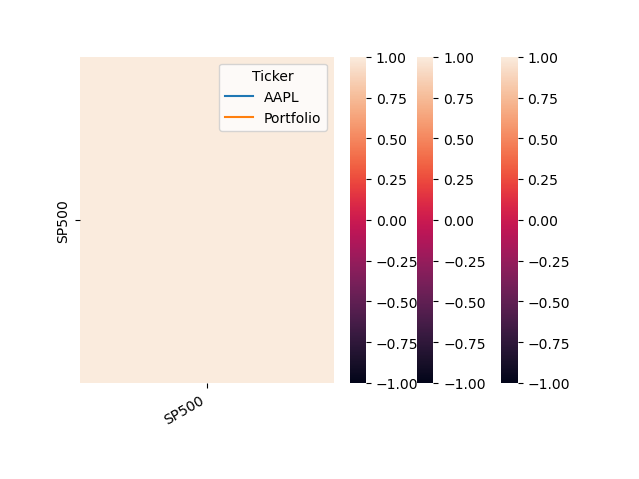
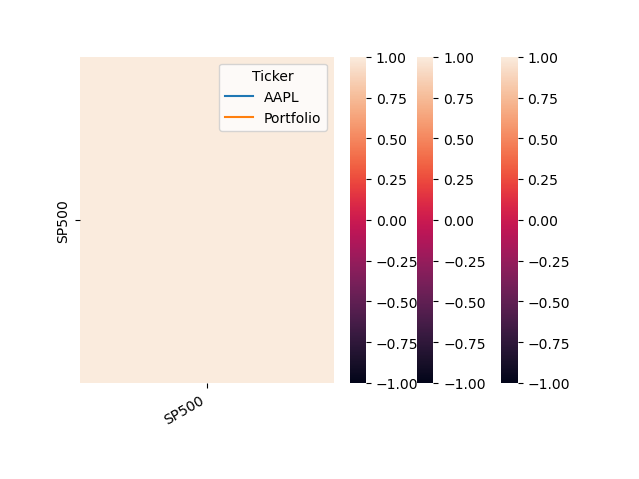
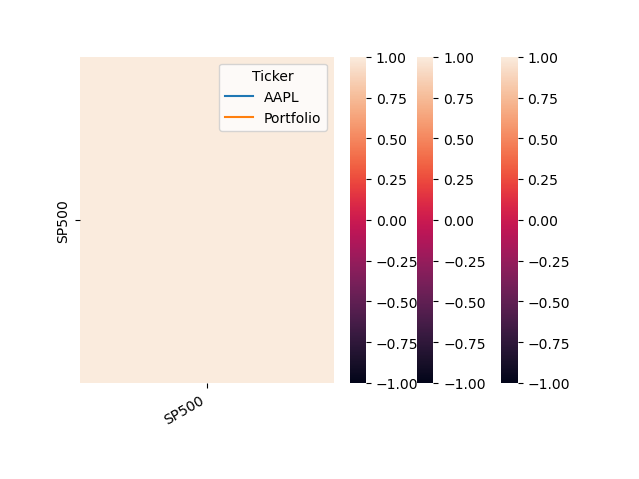

In [63]:
# Execute Panel dashboard using servable function
game_of_stock_dashboard.servable()